- In this notebook, I trained the ONet, which is the last part of the model
- As I mentioned in the first notebook (step 1), I will not show the repetitive parts. 

## Read ONet txt file
- In this part, it reads the txt file generated from the step 4.
- The format of the txt file is:
        image_path * label, gt_x1, gt_y1, gt_x2, gt_y2, cr_x1, cr_y1, cr_x2, cr_y2 + ... + label, gt_x1, gt_y1, gt_x2, gt_y2, cr_x1, cr_y1, cr_x2, cr_y2 * \n
- The output of this function is in the format:
        [image path, [box],[landmark]]

In [3]:
def create_onet_data_txt_parser(txt_path, img_dir,num_data=5000):

    if osp.exists(txt_path):
        img_faces = []
        with open(txt_path, 'r') as f:
            l = []
            lines = list(map(lambda line: line.strip().split('\n'), f))
            lines = [i[0] for i in lines]   
            shuffle(lines)
            img_count=0
            for line in lines:     
                if num_data is not None and img_count>=num_data:
                    break
                img_label_gt_crop=line.split('*')  
                real_img_path=img_label_gt_crop[0]
                gt_box=img_label_gt_crop[1]
                ldmk=img_label_gt_crop[2]
                boxes=img_label_gt_crop[3]
                boxes=[i.split(',') for i in boxes.split('+')]

                if osp.exists(real_img_path):
                    try:
                        Image.open(real_img_path).verify()
                        img_faces.append([real_img_path, gt_box,ldmk,boxes]) 
                        img_count+=1
                        
                    except:
                        print("*** warning:cannot open",real_img_path)

                else:
                    print("*** warning:image path invalid",real_img_path)

                

        return img_faces
    else:
        print('*** warning:WILDER_FACE txt file not exist!')


## Create the Inplace Dataset for ONet
- The input of this part is generated from the **create_onet_data_txt_parser** function

- The output of the **self.\__getitem \__ ** will be:
      (img_tensor, label, offset, landmark_flag, landmark)
      
- The **self.\__getitem \__ ** do the following things:  

    * It opens the corresponding image, and gets the figures of:
            label:            1 (if have face), 0 (else)
            ground truth boxes:  (gt_x1, gt_y1, gt_x2, gt_y2) 
            facial landmark:     (Lx1,Ly1,Lx2,Ly2,Lx3,Ly3,Lx4,Ly4,Lx5,Ly5)
            cropped boxes:      (cr_x1, cr_y1, cr_x2, cr_y2)
    * It randomly chooses a crop box from the list of crop boxes
    * It crops the image according to the seleted crop box
    * It calulated the offsets of the box and landmark

In [4]:
class InplaceDataset(data.Dataset):
    def __init__(self,  img_faces, cropsize):
        
        def cal_offset(face, box):
            offset = [
                (face[0] - box[0]) / float(box[2] - box[0]),
                (face[1] - box[1]) / float(box[3] - box[1]),
                (face[2] - box[2]) / float(box[2] - box[0]),
                (face[3] - box[3]) / float(box[3] - box[1]),
                ]
            return offset  
        def cal_landmark_offset(box, ldmk):
            if ldmk is None or box is None:
                return []
            else:
                minx, miny = box[0], box[1]
                w, h = box[2] - box[0], box[3] - box[1]
                ldmk_offset = [(ldmk[i] - [minx, miny][i % 2]) / float([w, h][i % 2]) for i in range(len(ldmk))]
                return ldmk_offset
        
        self.img_path=[]
        self.gt_box=[]
        self.ldmk=[]
        self.boxes=[]
        
        for img_face in img_faces:

            img_path=img_face[0]
            gt_box=[int(j) for j in img_face[1].split(',')]
            ldmk=[float(j) for j in img_face[2].split(',')]
            boxes=img_face[3]
            crop_offset_ldmk=[]
            for box in boxes:
                try:
                    label=box[0]
                    label=[1.0 if label in ['p', 'pf', 'l'] else 0.0]
                    crop_box=[int(j) for j in box[1:5]]
                    offset=cal_offset(gt_box, crop_box)
                    ldmk_offset=cal_landmark_offset(crop_box, ldmk)  
                    crop_offset_ldmk.append([label,crop_box,offset,ldmk_offset])
                except:
                    continue
            if len(crop_offset_ldmk) != 0:
                self.img_path.append(img_path)
                self.gt_box.append(gt_box)
                self.ldmk.append(ldmk)
                self.boxes.append(crop_offset_ldmk)
            else:
                print(img_path,'no box')

        self.crop_size = cropsize
        print('===> data set size:{}'.format(self.__len__()))       

       
      
    def __getitem__(self, index):
        
        img= np.array(Image.open(self.img_path[index]).convert('RGB'))
        crop_offset_ldmk=self.boxes[index]
        label,crop_box,offset,ldmk=crop_offset_ldmk[random.randint(0,len(crop_offset_ldmk))]
        landmark_flag = torch.FloatTensor([1.0 if label[0]==1.0 else 0.0])
        
        label=torch.FloatTensor(label)
        offset=torch.FloatTensor(offset)
        
        crop_img = img[crop_box[1]:crop_box[3], crop_box[0]:crop_box[2], :]
        crop_img = Image.fromarray(crop_img, mode='RGB').resize((self.crop_size , self.crop_size ), resample=PIL.Image.BILINEAR)    
        img_tensor = transforms.ToTensor()(crop_img)     

       
        landmark = torch.FloatTensor(ldmk)
        
        return (img_tensor, label, offset, landmark_flag, landmark)

    def __len__(self):
        return len(self.img_path)

## ONet Model

In [5]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias, 0.1)


class O_Net(nn.Module):
    def __init__(self):
        super(O_Net, self).__init__()
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1),  # conv1
            nn.PReLU(),  # prelu1
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool1
            nn.Conv2d(32, 64, kernel_size=3, stride=1),  # conv2
            nn.PReLU(),  # prelu2
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool2
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # conv3
            nn.PReLU(),  # prelu3
            nn.MaxPool2d(kernel_size=2, stride=2),  # pool3
            nn.Conv2d(64, 128, kernel_size=2, stride=1),  # conv4
            nn.PReLU()  # prelu4
        )
        self.conv5 = nn.Linear(128 * 2 * 2, 256)  # conv5
        self.prelu5 = nn.PReLU()  # prelu5
        # detection
        self.conv6_1 = nn.Linear(256, 1)
        # bounding box regression
        self.conv6_2 = nn.Linear(256, 4)
        # lanbmark localization
        self.conv6_3 = nn.Linear(256, 10)
        # weight initiation weih xavier
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv5(x)
        x = self.prelu5(x)
        # detection
        det = torch.sigmoid(self.conv6_1(x))
        box = self.conv6_2(x)
        landmark = self.conv6_3(x)
        return det, box, landmark




## Training

- If there is no prediction box, it will print:
         "image_path no box"

In [8]:
DEVICE = torch.device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')
train_txt_path='../input/landmark/ldmk_onet_train_data.txt'
eval_txt_path='../input/landmark/ldmk_onet_eval_data.txt'
train_img_path='../input/facial-point-detection'
eval_img_path='../input/facial-point-detection'
onet_weight_path='../input/landmark/onet_12708_60_2.pkl'
train_num=None
eval_num=None
class_data_augment = 3 
LR = 0.001
EPOCH = 60
BATCH_SIZE = 32
NUM_WORKS = 8
Rnet_loss_config = [1.0, 0.5, 1.0]

train_img_faces = create_onet_data_txt_parser(train_txt_path,train_img_path ,num_data=train_num)
eval_img_faces = create_onet_data_txt_parser(eval_txt_path,eval_img_path ,num_data=eval_num)
train_IDS=InplaceDataset(train_img_faces, cropsize=48)
eval_IDS=InplaceDataset(eval_img_faces, cropsize=48)
Train_Loader=DataLoader(train_IDS,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKS,pin_memory=False)
Eval_Loader=DataLoader(eval_IDS,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKS,pin_memory=False)
train_num=len(train_IDS)
eval_num=len(eval_IDS)

net=O_Net().cuda()
net.load_state_dict(torch.load(onet_weight_path))

../input/facial-point-detection/Facial_Point_Detection/net_7876/1118_1_0.jpg no box
../input/facial-point-detection/Facial_Point_Detection/net_7876/_-20_1332_2.jpg no box
../input/facial-point-detection/Facial_Point_Detection/net_7876/_-20_1483_1.jpg no box
===> data set size:9995
../input/facial-point-detection/Facial_Point_Detection/net_7876/7879_3_0.jpg no box
===> data set size:3435


<All keys matched successfully>

In [9]:
train_losses,eval_losses,rnet=train_net(net, net_name='onet',  loss_config=Rnet_loss_config)

===> epoch:0	| train_loss:0.20185278	| time:34.99037102s
                | eval_loss:0.15683113	| time:11.26207389s
===> epoch:1	| train_loss:0.13381252	| time:34.43137759s
                | eval_loss:0.14448112	| time:11.66334475s
===> epoch:2	| train_loss:0.12436798	| time:33.69353776s
                | eval_loss:0.12028574	| time:11.69709985s
===> epoch:3	| train_loss:0.11492737	| time:34.41008944s
                | eval_loss:0.11984591	| time:11.77302263s
===> epoch:4	| train_loss:0.11002771	| time:34.72335959s
                | eval_loss:0.13410058	| time:11.48349234s
===> epoch:5	| train_loss:0.11807307	| time:34.60082630s
                | eval_loss:0.14071780	| time:11.55943728s
===> epoch:6	| train_loss:0.10884236	| time:33.63942360s
                | eval_loss:0.12892421	| time:12.17372432s
===> epoch:7	| train_loss:0.10850325	| time:33.76798345s
                | eval_loss:0.14369320	| time:11.31702124s
===> epoch:8	| train_loss:0.10490859	| time:34.96860804s
               

## Show the Loss Curve

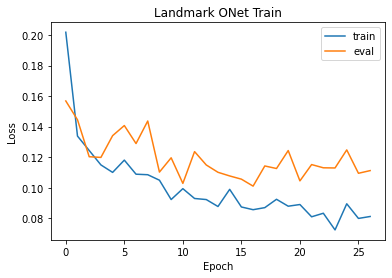

In [10]:
x=np.arange(len(train_losses))
plt.plot(x,train_losses,label='train')
plt.plot(x,eval_losses,label='eval')
plt.title('Landmark ONet Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()